This notebook can be used for making and visualizing the images of the L20C1 dataset. This was copied and edited to _only_ take in the L20C1 dataset, as opposed to the original version of this notebook which took in the aggregated dataset. You can choose which stats and which color channels to map to which values of the sequencing data.

In [72]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import itertools as it

## 1. Read in Adata and Spatial Barcodes

In [73]:
prefix = '/data/xyzeq/xyzeq/'

In [84]:
adata = sc.read_h5ad(prefix + 'individual.raw.and.proc.h5ads/fig3.L20C1/adata.6.h5ad')

In [85]:
spatial = pd.read_csv(prefix + 'plate23_map.csv', header=None, index_col=0)
spatial.columns = ['X','Y']

In [86]:
spatial

,X,Y
0,,
AGTTGTTCTAGCGCCT,1,1
CCGTTAGACGTGACAG,1,2
CTTACGGTCCGTACGT,1,3
TCCTGCATTGTGAGAA,1,4
CTGCGCACTGCTTCTT,1,5
...,...,...
CCTGTTGTATGGTTAC,44,2
TCAATCTATGAGTCGC,44,3
TCGCGACTGCCACTAC,44,4


In [87]:
spatial.iloc[-20:,:]

,X,Y
0,,
CGCACTATAGGTTAAG,42,11
ATCGCGGTTCCTGAGG,42,12
AGTAGAGTTATCGTCC,42,13
GCTTGACCGTAATCGA,42,14
CGGCTCATTACTGCGG,42,15
GGACGCCTACAATGAT,42,16
TACATCGACGAACCTG,42,17
AGCGGAGAGTCAAGCT,42,18
GCATCCAATCGCGTTA,43,1


X indices 43 and 44 don't have a full set of Y indices. These indices are on the edge of the array and are complicating some of the operations further downstream. Because I've examined some of the outputs and they do not seem to be terribly useful anyway (probably contain very few cells), I'm going to drop them for now. I will do this after I add the columns to the `adata.obs`.

In [88]:
adata.obs['spatial_bc'] = [i.split('.')[1].split('-')[0] for i in adata.obs_names]

In [89]:
adata.obs['X'] = list(map(lambda x: spatial.loc[x,'X'], adata.obs['spatial_bc']))
adata.obs['Y'] = list(map(lambda x: spatial.loc[x,'Y'], adata.obs['spatial_bc']))

In [90]:
sum(adata.obs['X'] > 42)

28

Only 28 cells in these wells. Let's just drop them.

In [91]:
adata = adata[adata.obs['X'] <= 42].copy()

Because we're only using L20C1, we only have one batch. I could change all the code to just avoid using the batch variable, or I could just add it here and only input '1' for everything. That's the path of least resistance so going to do that here:

In [92]:
adata.obs['batch'] = ['1' for _ in range(adata.shape[0])]

In [94]:
# adata.write(prefix + 'individual.raw.and.proc.h5ads/fig3.L20C1/adata.6.xy.h5ad')
adata = sc.read_h5ad(prefix + 'individual.raw.and.proc.h5ads/fig3.L20C1/adata.6.xy.h5ad')

## 2. Build the HexMap
Instead of relying on matplotlib, for many reasons I've decided to just build the image manually using a numpy array.

When considering the hexagons:
1. We want something as small as possible because for super resolution we will be registering to _pixel_ resolution. 
2. We need something that stacks. I don't know the theory or jargon around this, but I've determined (mostly through trial and error) we need something with an even number of pixels per side to prevent single-pixel points on the sides, as those don't stack.

I've come to the conclusion that the smallest, most-hexagon-like figure we can generate is the one that fits inside a 12 x 12 pixel grid.

In [35]:
myhex = np.zeros((12,12)) 

In [36]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

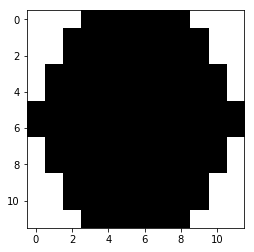

In [37]:
plt.imshow(myhex, cmap='binary');

Our hexagon has 6 pixel-long sides on top and bottom. If it were a true hexagon, the pixels on the vertical sides would also be 6 units long. We can try to measure one by using the length of the right triangle formed from the 3 pixels jutting out and 6 pixels high, which ends up creating a hypotenuse vertical side of theortical 6.71 units long, so 6 ~ 6.7, I'd say is close enough (~10% off) to true hexagon. The 12-pixel-long hexagon also has the added benefit of spatial resolution to around the diameter of a cell (500/12 is 40 um, roughly the size of what I'd imagine are the largest cells we'll be picking up). 

Now building the array of hexagons. I will mark the location of key points of each hexagons in a lookup dataframe called `hex_coords` so I don't have to build it everytime I need to fill in new values.

In [38]:
# make a lookup table, so that I don't have to do all these calculations again
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,43), range(1,19)], names=['X','Y']),
                          columns=['hex_xstart','hex_ystart', 'center_xstart', 'center_ystart', 'hex_xend', 'hex_yend'])

for y, x in it.product(range(1,19),range(1,43)):
    xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
    ystart = (y-1)*12
    if x % 2 == 0:  
        ystart = ystart + 6

    # make a lookup table, so that I don't have to do all these calculations again
    hex_coords.loc[(x,y),'hex_xstart'] = xstart
    hex_coords.loc[(x,y),'hex_ystart'] = ystart
    hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
    hex_coords.loc[(x,y),'center_ystart'] = ystart + 5
    hex_coords.loc[(x,y),'hex_xend'] = xstart + 12
    hex_coords.loc[(x,y),'hex_yend'] = ystart + 12
# hex_coords = hex_coords.astype(np.uint8) # definitely don't convert to integers, it will mess things up, not quite sure how exactly at the current moment

Now fill in the hex array with random colors to show it works.

In [39]:
img = list()
for color in ['r','g','b']:
    hex_array = np.zeros((222,381)) # these are calculated to perfectly encapsulate the 19 x 43 well array
    for y, x in it.product(range(1,19),range(1,43)):
        
        val = np.random.choice(range(50,255))
        
        xstart = hex_coords.loc[(x,y),'hex_xstart']
        ystart = hex_coords.loc[(x,y),'hex_ystart']

        yend = hex_coords.loc[(x,y),'hex_yend']
        xend = hex_coords.loc[(x,y),'hex_xend']
        
        current_hex = hex_array[ystart:yend,xstart:xend]
        hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
    img.append(hex_array)
img = np.stack(img, axis=2).astype(np.uint8)

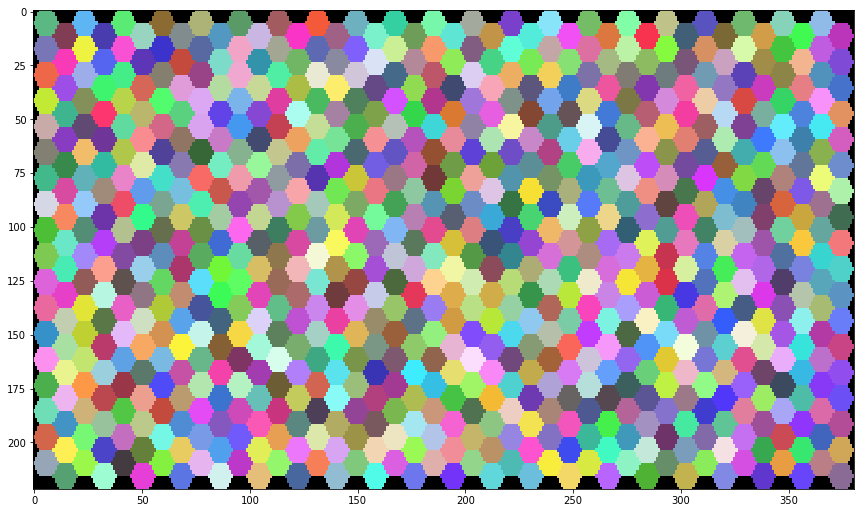

In [40]:
plt.figure(figsize=(400/25,220/25)) # chose this size to keep the aspect ratio
plt.imshow(img, cmap='binary');

I would also like to make a list of neighbors for each well for use later. Neighbors are divided into layers of proximity, where the layer corresponds to the least number of jumps from one well to the neighbor, which I imagine this perfectly correlates with, or at least very well approximates, true physical distance of a cell in one well to another given our resolution. 

So I wrote a function to get immediate neighbors which works well. However, if we think about it, neighbors of well _(x, y)_ of layer _L_ = 2 are just the **_new_** neighbors of those wells of _L_ = 1. This can be formalized with better and notation, but in essence we just need to iteratively get the immediate neighbors of our neighbors to get those layers that are more than 1 away. Because I calculate immediate neighbors once and store it in the `hex_coords` Dataframe, I don't need to iteratively call the function but rather just look up the neighbors.

Very proud of the two cells below, although this *might* have been easier with just applying a function that could probably do this for perfectly orthogonal coordinates and then just shifting every other row up or down by one.

In [41]:
def immediate_neighbors(x, y):
    if x % 2 == 0:
        neighbors = np.array([(x-1, y+1), (x, y+1), (x+1, y+1), (x-1, y), (x+1, y), (x, y-1)])
    else:
        neighbors = np.array([(x-1, y-1), (x, y-1), (x+1, y-1), (x-1, y), (x+1, y), (x, y+1)])
    
    neighbors = np.array([i for i in neighbors if not np.any(i <= 0)
                     and not np.any(i[0] > 42) 
                     and not np.any(i[1] > 18)]) # remove those that are outside array bounds
    neighbors = set(tuple(i) for i in neighbors) # convert to set for easier manipulation alter
    return neighbors

In [ ]:
for layer in range(1,11):
    if layer == 1:
        # exclude has one key for each well, and value = set() of wells to exclude when trying to determine the newest layer of neighbors
        # for each layer, value set() grows by set of wells that have already been included in a neighbor set + the center well in question
        # tried to make `exclude` a col in the df, but pands was giving me trouble for setting a value of df to a set()
        exclude = dict() 
        
        # a list of neighbors that will become the column in the df
        neighbors_list = list()
        for x, y in tqdm(it.product(range(1,43), range(1,19)),total=42*18):
            neighbors = immediate_neighbors(x, y) # get the immediate neighbors
            neighbors_list.append(neighbors) # add them to the list of neighbors
            exclude[(x,y)] = neighbors.union(set([(x,y)])) # add the well in question
    else:
        neighbors_list = list() 
        
        for x, y in tqdm(it.product(range(1,43), range(1,19)),total=42*18):
            neighbors_2 = set() # neighbors "squared", i.e. the neighbors of the neighbors in question
            
            for neighbor in hex_coords.loc[(x, y), 'neighbors_%s' % (layer-1)]: # for each neighbor...,
                neighbors_2 = neighbors_2.union(hex_coords.loc[neighbor,'neighbors_1']) # ..., get its immediate neighbors
                
            new_neighbors = neighbors_2.difference(exclude[(x,y)]) # exclude the neighbors that are already in a neighbors list
            exclude[(x,y)] = exclude[(x,y)].union(new_neighbors) # update the exclude set() with the new neighbors
            neighbors_list.append(new_neighbors)
    hex_coords['neighbors_%s' % layer] = neighbors_list # put the neighbors list in the df

In [13]:
hex_coords[[i for i in hex_coords.columns if i.startswith('neighbors')]].head()

neighbors_1  \
X Y                                     
1 1                  {(1, 2), (2, 1)}   
  2  {(1, 3), (1, 1), (2, 1), (2, 2)}   
  3  {(1, 2), (2, 3), (1, 4), (2, 2)}   
  4  {(1, 5), (1, 3), (2, 3), (2, 4)}   
  5  {(2, 5), (1, 6), (2, 4), (1, 4)}   

                                           neighbors_2  \
X Y                                                      
1 1                   {(3, 2), (1, 3), (3, 1), (2, 2)}   
  2           {(3, 2), (3, 3), (3, 1), (1, 4), (2, 3)}   
  3  {(3, 2), (3, 3), (2, 1), (1, 5), (2, 4), (3, 4...   
  4  {(1, 2), (3, 3), (1, 6), (2, 2), (2, 5), (3, 4...   
  5  {(2, 6), (1, 3), (2, 3), (3, 6), (1, 7), (3, 4...   

                                           neighbors_3  \
X Y                                                      
1 1           {(3, 3), (1, 4), (2, 3), (4, 2), (4, 1)}   
  2   {(1, 5), (4, 3), (3, 4), (4, 2), (4, 1), (2, 4)}   
  3  {(3, 1), (4, 4), (1, 6), (4, 3), (4, 2), (2, 5...   
  4  {(3, 2), (2, 6), (4, 5), (4, 4), (2, 1), (4, 3...   
  5  {(2, 7), (1, 2), (4, 6), (3, 3), (4, 5), (4, 4...   

                                           neighbors_4  \
X Y                                                      
1 1  {(5, 2), (1, 5), (4, 3), (5, 1), (3, 4), (2, 4...   
  2  {(5, 4), (3, 5), (4, 4), (1, 6), (5, 1), (2, 5...   
  3  {(5, 4), (2, 6), (5, 5), (4, 5), (3, 6), (1, 7...   
  4  {(2, 7), (5, 4), (4, 6), (5, 5), (5, 6), (3, 1...   
  5  {(5, 4), (3, 2), (4, 7), (5, 5), (5, 6), (2, 8...   

                                           neighbors_5  \
X Y                                                      
1 1  {(5, 4), (6, 1), (4, 4), (6, 3), (6, 2), (1, 6...   
  2  {(6, 4), (2, 6), (5, 5), (4, 5), (6, 1), (6, 3...   
  3  {(2, 7), (6, 4), (4, 6), (5, 6), (6, 1), (6, 3...   
  4  {(6, 4), (4, 7), (6, 6), (2, 8), (6, 1), (5, 7...   
  5  {(6, 4), (4, 1), (6, 7), (2, 9), (4, 8), (6, 6...   

                                           neighbors_6  \
X Y                                                      
1 1  {(6, 4), (7, 3), (2, 6), (5, 5), (7, 1), (4, 5...   
  2  {(2, 7), (7, 3), (4, 6), (7, 1), (5, 6), (7, 4...   
  3  {(7, 3), (4, 7), (6, 6), (7, 1), (2, 8), (7, 6...   
  4  {(7, 3), (6, 7), (2, 9), (4, 8), (7, 1), (7, 6...   
  5  {(5, 9), (7, 3), (4, 9), (6, 8), (3, 10), (7, ...   

                                           neighbors_7  \
X Y                                                      
1 1  {(2, 7), (8, 3), (4, 6), (8, 2), (5, 6), (8, 1...   
  2  {(4, 7), (8, 3), (8, 2), (6, 6), (8, 1), (2, 8...   
  3  {(8, 3), (6, 7), (8, 2), (2, 9), (4, 8), (8, 1...   
  4  {(5, 9), (8, 3), (4, 9), (8, 2), (6, 8), (8, 1...   
  5  {(4, 10), (6, 9), (8, 3), (5, 10), (8, 2), (1,...   

                                           neighbors_8  \
X Y                                                      
1 1  {(4, 7), (9, 1), (6, 6), (9, 2), (2, 8), (7, 6...   
  2  {(8, 6), (6, 7), (9, 1), (2, 9), (4, 8), (9, 2...   
  3  {(5, 9), (4, 9), (9, 1), (6, 8), (9, 2), (3, 1...   
  4  {(4, 10), (6, 9), (9, 7), (5, 10), (9, 1), (1,...   
  5  {(3, 12), (9, 1), (5, 11), (9, 2), (1, 13), (9...   

                                           neighbors_9  \
X Y                                                      
1 1  {(10, 3), (10, 5), (6, 7), (10, 4), (2, 9), (4...   
  2  {(5, 9), (10, 5), (10, 3), (4, 9), (10, 4), (6...   
  3  {(4, 10), (6, 9), (10, 5), (5, 10), (10, 4), (...   
  4  {(10, 8), (10, 5), (3, 12), (10, 4), (5, 11), ...   
  5  {(10, 8), (10, 5), (10, 4), (3, 13), (10, 7), ...   

                                          neighbors_10  
X Y                                                     
1 1  {(5, 9), (11, 4), (4, 9), (6, 8), (11, 5), (11...  
  2  {(4, 10), (6, 9), (11, 7), (11, 4), (5, 10), (...  
  3  {(10, 8), (11, 7), (3, 12), (11, 4), (11, 5), ...  
  4  {(11, 7), (11, 4), (3, 13), (11, 5), (6, 11), ...  
  5  {(11, 7), (11, 10), (11, 4), (11, 5), (7, 12),...

In [43]:
# hex_coords.to_pickle(prefix + 'concatenated.deep/deep2/hex.coords.pkl')
hex_coords = pd.read_pickle(prefix + 'concatenated.deep/deep2/hex.coords.pkl')

## 3. Make Images

There are several ways to make images. The two methods we wanted to try first are as follows:

1. Using the percentage of cells in a well that are MC38 vs Hepatocytes as the pixel value 
2. Using the counts of transcripts in cells across the most differentially expressed genes. 

Method 1 is simpler, but method 2 may provide more information. In this notebook, I will try method 1, but I may create another notebook looking into method 2.

#### Build a Counts DataFrame

In [49]:
batches = adata.obs['batch'].unique()

In [55]:
celltype_string = 'celltype'

In [56]:
celltypes = adata.obs[celltype_string].unique()

In [57]:
celltypes

[Hepatocyte, Hek293t, Kupffer, Lymphocyte, LSECs, Macrophage, mc38]
Categories (7, object): [Hepatocyte, Hek293t, Kupffer, Lymphocyte, LSECs, Macrophage, mc38]

Initialize a counts dataframe that will contain the counts, per well and per batch, of each cell type. I'm going to use `pd.MultiIndex` to index according to `X`, `Y`, and `batch`. The MultiIndex, while useful, also causes some problems with by creating these indices of dtype `Category` that are hard to edit later. I try to remedy those issues by converting the columns to a regular index here, and then set the batch to an integer dtype after I build the counts dataframe. Converting to the batch to an integer is useful later.

In [58]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=celltypes)
counts.columns = pd.Index(list(counts.columns)) # this is to convert the columns into a normal index and not a categorical index, not sure why it does that when using multiindex.from_product

In [59]:
counts.columns

Index(['Hepatocyte', 'Hek293t', 'Kupffer', 'Lymphocyte', 'LSECs', 'Macrophage',
       'mc38'],
      dtype='object')

Subset the adata into smaller adatas according to their batch.

In [60]:
adata_subs = dict()

In [61]:
for batch in batches:
    adata_subs[batch] = adata[adata.obs['batch'] == batch].copy()

Fill the counts dataframe.

In [62]:
for batch, x, y in tqdm(counts.index):
    xy_cts = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].obs[celltype_string]
    cts, ct_counts = np.unique(xy_cts.values, return_counts=True)
    for ct, ct_count in zip(cts, ct_counts):
        counts.loc[(batch, x, y),ct] = ct_count

This is where I convert the batch to an integer, it makes things easier later.

In [63]:
counts.index = counts.index.set_levels([counts.index.levels[0].astype(np.uint8), counts.index.levels[1], counts.index.levels[2]])

Going to run the above cells twice and pickle the values so I don't have to run in the future.

In [65]:
# counts.to_pickle(prefix + 'individual.raw.and.proc.h5ads/fig3.L20C1/counts.celltype.pkl')
counts = pd.read_pickle(prefix + 'individual.raw.and.proc.h5ads/fig3.L20C1/counts.celltype.pkl')

#### Fill in the Hexarray with Color Values

In [66]:
def get_colors(df, cts, color=True, prop_den=None, clip_cts=None, clip_tots=None):
    '''
    This function takes in the counts of each cell type from the DataFrame and 
    will generate color values based on the proportion of cells in each well
    that are the celltype(s) of interest. If color set to False, will just
    return the actual proportion of each cell type not scaled to RGB values.
    
    cts is a list of celltypes.
    
    For calculating proportion, will use a denomintaor of the total of only the provided 
    cell types (prop_den='cts') or the total of all cells (prop_den='tot'). If not
    provided, for len(ct) == 1 will set to 'tot', else will use 'cts'.
    
    `clip_cts` (list, same length as cts) will floor counts to zero before doing
    proportion calculations. `clip_tots` (int) will floor color values to zero
    of wells that don't contain at least that many cells.
    
    Plotting raw counts is kind of unmeaningful, so skipping that for now.
    '''
    assert type(cts) == type(list())
    
    if type(clip_cts) == type(None):
        clip_cts = [0]*len(cts)
    else:
        assert len(clip_cts) == len(cts)

    if type(prop_den) == type(None):
        # will fill in with what I think is appropriate if not provided
        if len(cts) == 1:
            prop_den = 'tot'
        else:
            prop_den = 'cts'
            
    # actually get the denominator
    if prop_den == 'cts':
        prop_den_vals = df[cts].sum(axis=1).values
    elif prop_den == 'tot':
        prop_den_vals = df.sum(axis=1).values
    else:
        raise ValueError

    
    val_dict = dict() 
    val_arrs = [np.zeros((len(df),))]*3 
    
    for i in range(len(cts)):
        ct = cts[i]
        val_dict[ct] = df[ct].values
        clip_val = clip_cts[i]
        val_dict[ct] = np.where(val_dict[ct] < clip_val, 0, val_dict[ct])
        with np.errstate(invalid='ignore'):
            val_dict[ct] = val_dict[ct] / prop_den_vals # this produces Nans, but they get replaced with 0 when converting to np.uint8
        val_arrs[i] = val_dict[ct]
        
    if color == True:
        colors = [255*i for i in val_arrs]
        colors = np.stack(colors, axis=1).astype(np.uint8)
        val_df = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
    else:
        props = np.nan_to_num(np.stack(val_arrs[:len(cts)], axis=1))
        val_df = pd.DataFrame(props, index=df.index, columns=['%' + '%s/%s' % (ct, prop_den) for ct in cts])
    
    if type(clip_tots) != type(None):
        tot = df.sum(axis=1).values
        clip_tot_mask = tot >= clip_tots
        clip_tot_mask = np.array([clip_tot_mask]*3).astype(bool).T
        val_df.where(clip_tot_mask,0,inplace=True)
                              
#     val_df = val_df[val_df.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return val_df

In [67]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

First, just color by total count:

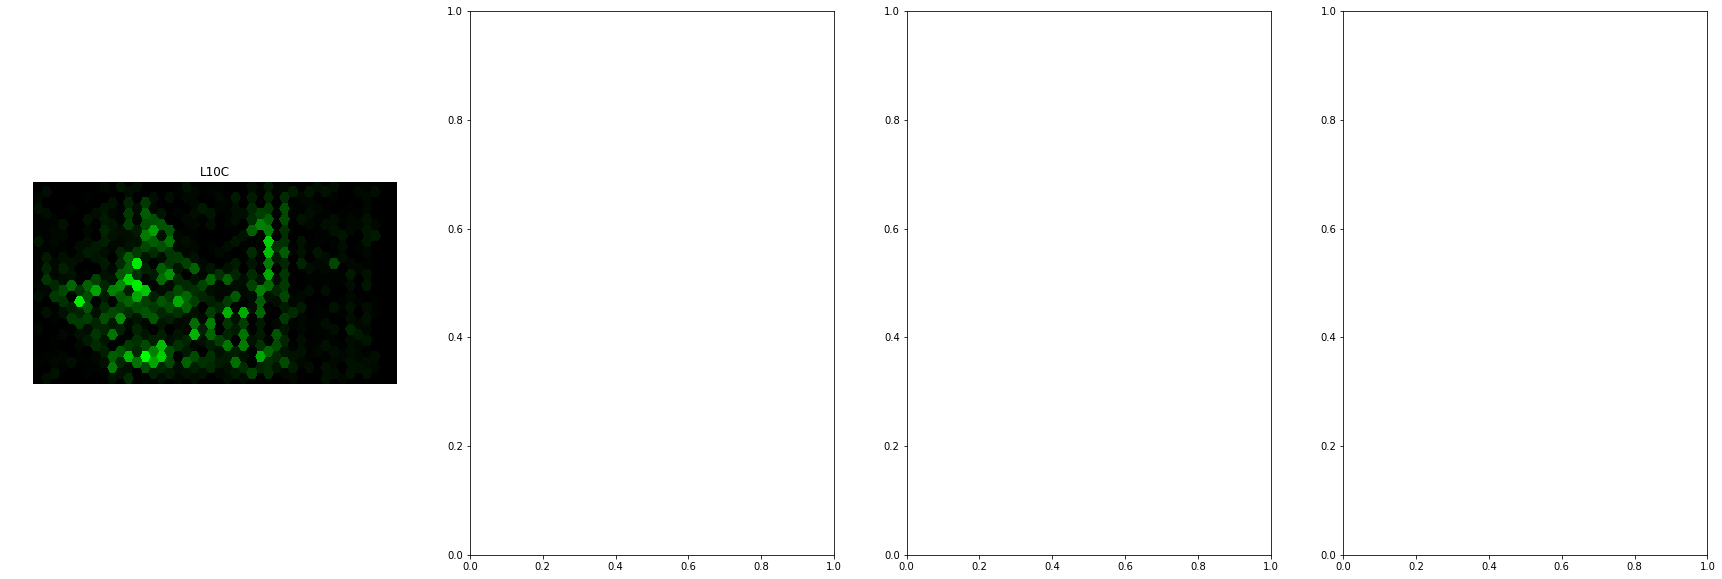

In [68]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
    tot = counts.loc[batch].sum(axis=1)
    tot = np.uint8(tot/tot.max()*255)
    color_df['g'] = tot
    img = get_image(color_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['L10C', 'L20C1', 'L20T', 'L30C']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

Next, color by %Hepatocyte vs %Cancer:

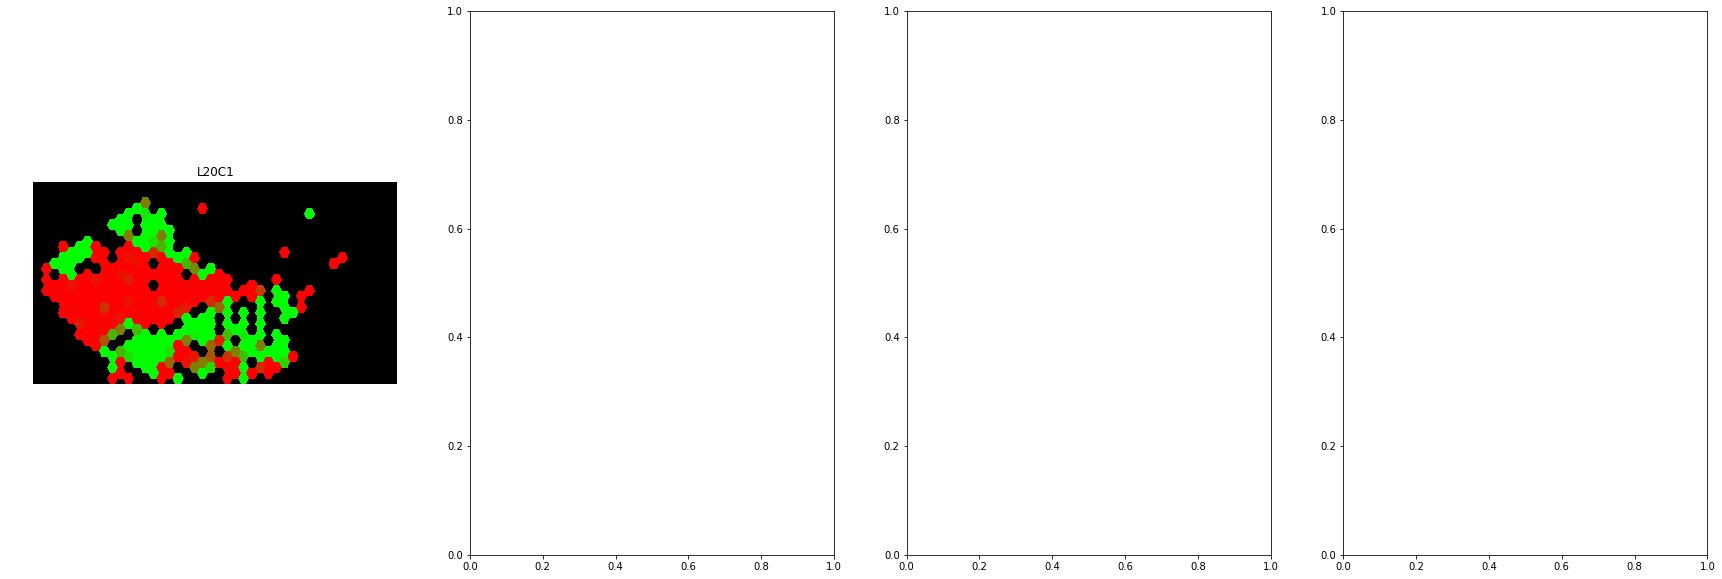

In [70]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts.loc[batch], cts=['Hepatocyte', 'mc38'])
    img = get_image(color_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['L20C1']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

There seems to be a lot of spurious wells, that, based on the total counts from the well, would not be showing up as red or green. I want to see if I can use the `clip_tots` functionality to try filtering out those isolated wells, ones that a binary closing would remove.

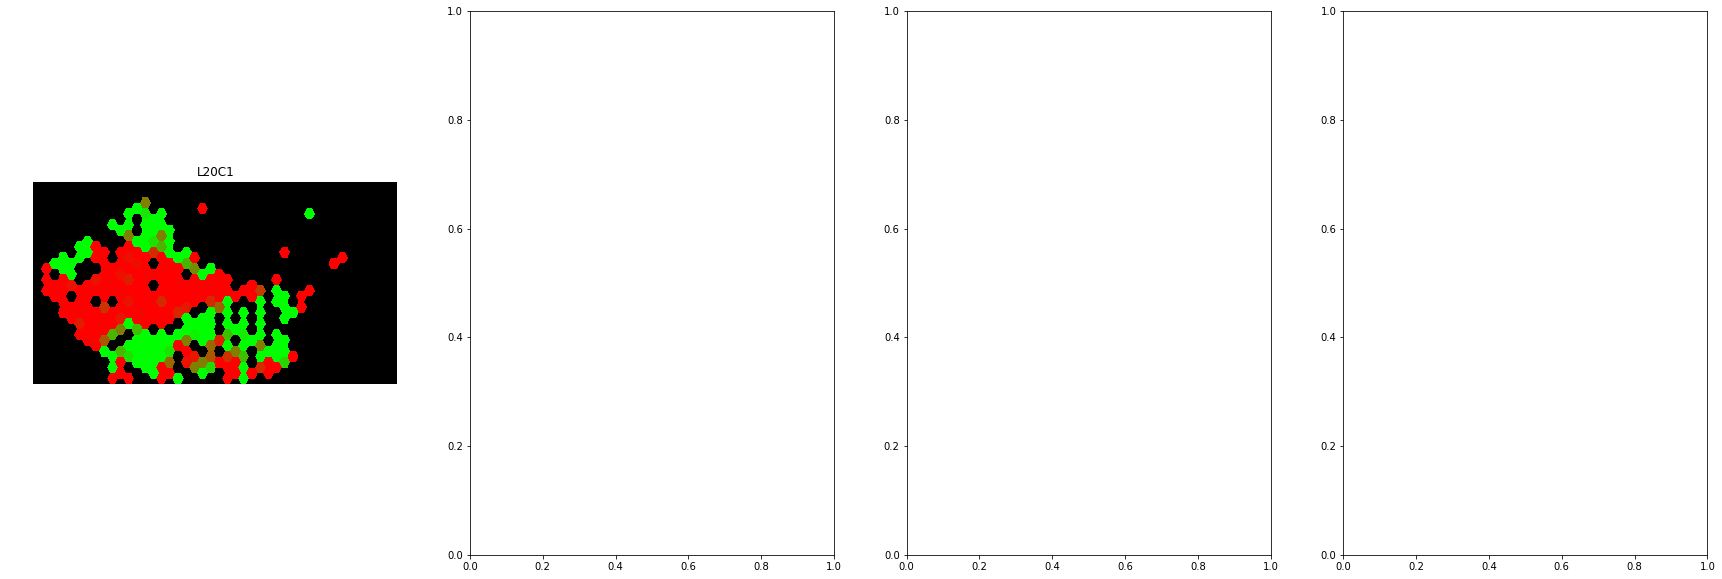

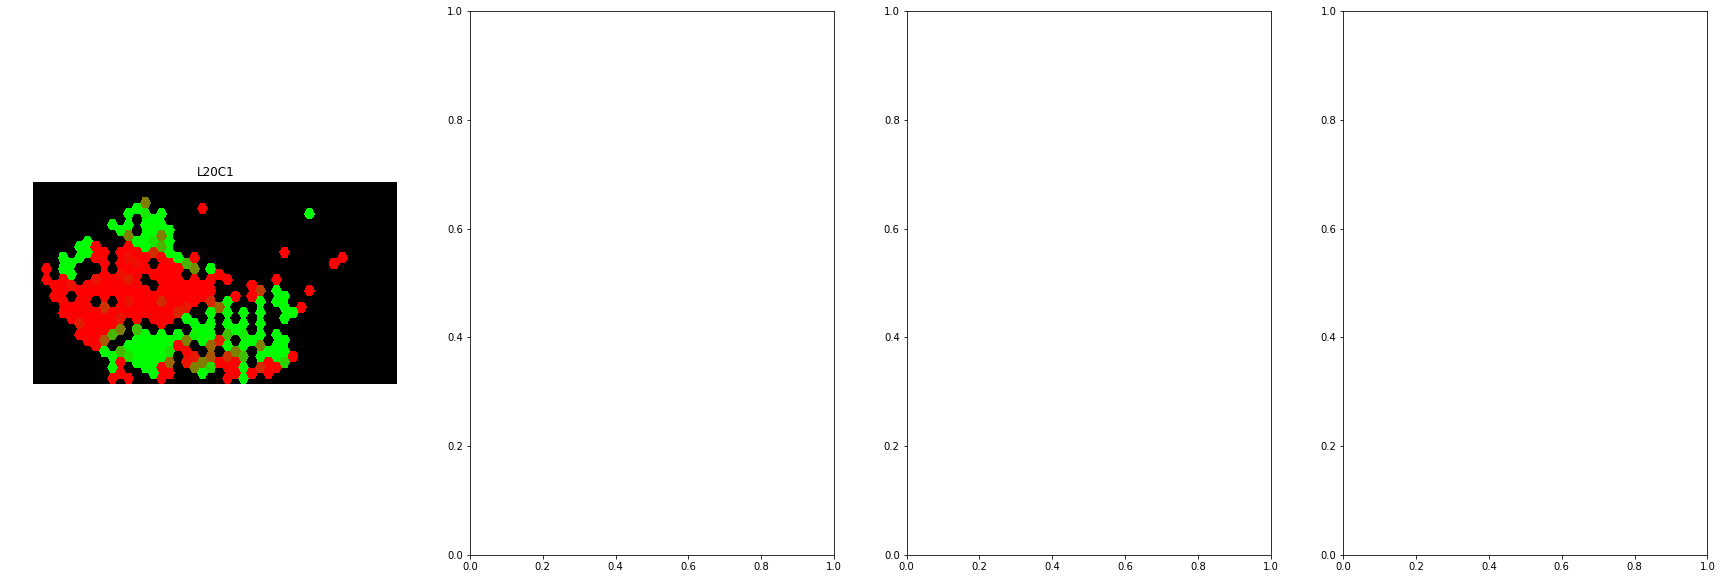

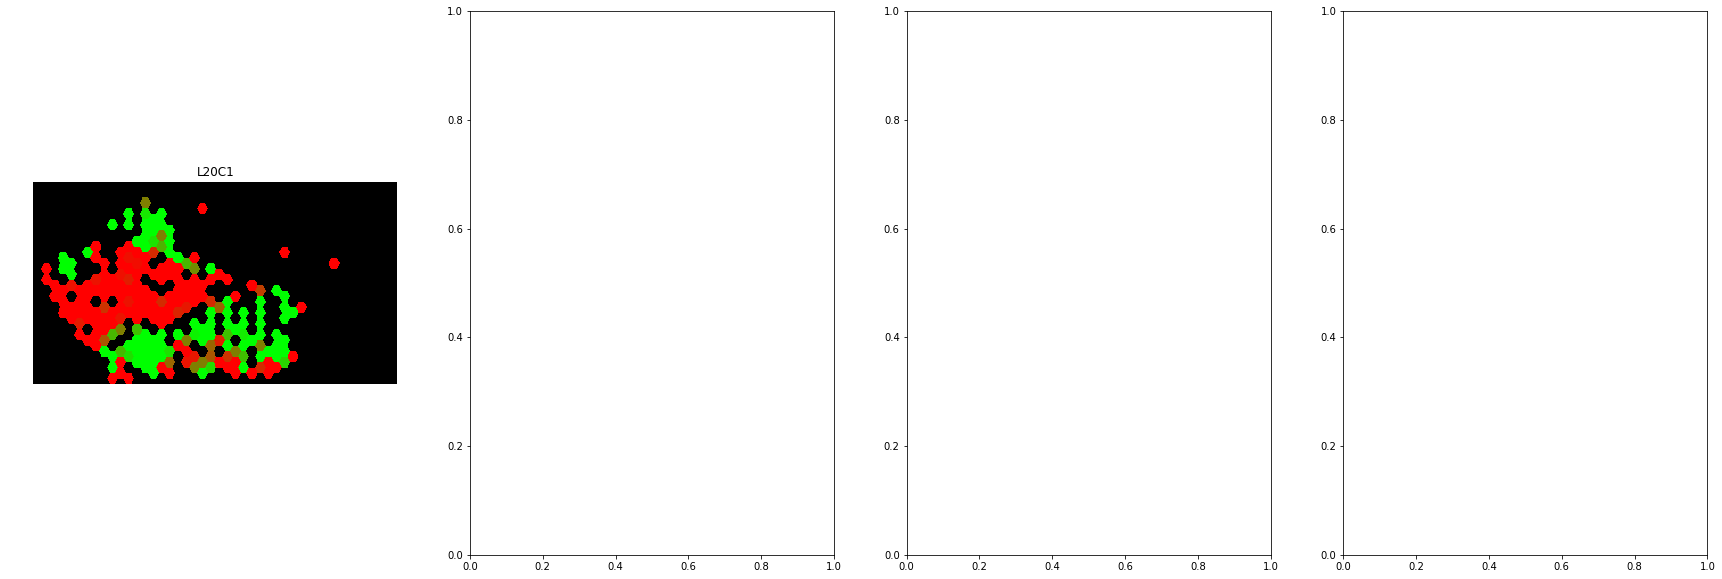

In [71]:
clip_tots_threshs = range(2,5) # I've introduced this to try to clean up a lot of the isolated wells that are lighting up

for clip_tot in clip_tots_threshs:
    clip_tots = [clip_tot]*4
    img_list = list()
    for batch, clip in tqdm(zip(counts.index.get_level_values('batch').unique(), clip_tots), total=4):
        images = list()
        color_df = get_colors(counts.loc[batch], cts=['Hepatocyte', 'mc38'], clip_tots=clip)
        img = get_image(color_df)
        img_list.append(img)
    fig, axes = plt.subplots(1,4, figsize=(30,10))
    for img, ax, title in zip(img_list, np.ravel(axes), ['L20C1']):
        ax.imshow(img);
        ax.set_title(title)
        ax.axis('off')

Okay, doesn't seem like theres a single threshold to apply to all the slices that would remove those and not remove the wells I'm more confident in. My suggestion to remove those is:

1. Plot all percentages (not filtered for hepatocyte, MC38, or total counts).
2. Do a _binary closing_ on all the wells. This will remove any that are completely isolated. 
3. Iteratively remove wells connected to the main mass by only one well until no more improvement.

I think it would also benefit thinking about this in the context of graph theory. Wells are nodes connected to eachother by their immediate neighbors (or by edges weighted by their proximity). It may have made all the calculations much easier, so if I revisit the calculations, I should consider using a graphing package.